# EPA Fuel Economy Data Assessment

This jupyter notebook provides an assessment of EPA fuel economy data from 2018 and 2008.

To download data: https://www.fueleconomy.gov/feg/download.shtml

Documentation: https://www.fueleconomy.gov/feg/EPAGreenGuide/GreenVehicleGuideDocumentation.pdf

README.txt: http://www.fueleconomy.gov/feg/epadata/Readme.txt

In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

#import and assess the 2008 data
temp_08 = pd.read_excel("https://www.fueleconomy.gov/feg/EPAGreenGuide/xls/all_alpha_08.xls")
temp_18 = pd.read_excel('https://www.fueleconomy.gov/feg/EPAGreenGuide/xls/all_alpha_18.xlsx')

# REMOVE THE BELOW

In [200]:
df_08 = temp_08.copy()
df_18 = temp_18.copy()

print(df_08.shape, "\n", df_18.shape)

(2404, 18) 
 (2682, 18)


In [201]:
#evaluate column labels to determine if they are aligned
print("2008", df_08.columns, "2018", df_18.columns, 
      "\nDo all columns match?",
      (df_08.columns == df_18.columns).all(),
      sep='\n')

2008
Index(['Model', 'Displ', 'Cyl', 'Trans', 'Drive', 'Fuel', 'Sales Area', 'Stnd',
       'Underhood ID', 'Veh Class', 'Air Pollution Score', 'FE Calc Appr',
       'City MPG', 'Hwy MPG', 'Cmb MPG', 'Unadj Cmb MPG',
       'Greenhouse Gas Score', 'SmartWay'],
      dtype='object')
2018
Index(['Model', 'Displ', 'Cyl', 'Trans', 'Drive', 'Fuel', 'Cert Region',
       'Stnd', 'Stnd Description', 'Underhood ID', 'Veh Class',
       'Air Pollution Score', 'City MPG', 'Hwy MPG', 'Cmb MPG',
       'Greenhouse Gas Score', 'SmartWay', 'Comb CO2'],
      dtype='object')

Do all columns match?
False


In [202]:
def clean_columns(df):

    #Make columns lowercase and replace spaces with underscores in column names
    df.rename(columns=lambda x: x.strip().lower().replace(" ", "_"), inplace=True)
    
    #remove null values and duplicates
    df.drop_duplicates(inplace=True)
    df.dropna(inplace=True)
    
    return df

In [203]:
#dropping columns that are not present in both datasets or are unnecessary for evaluation
df_08.drop(['Stnd', 'Underhood ID', 'FE Calc Appr', 'Unadj Cmb MPG'],axis=1,inplace=True)
df_18.drop(['Stnd', 'Stnd Description', 'Underhood ID', 'Comb CO2'],axis=1,inplace=True)

#renaming columns for consistency in 2008 only

df_08.rename(columns={'Sales Area':'Cert Region'}, inplace=True)

df_08 = clean_columns(df_08)
df_18 = clean_columns(df_18)

Following columns do not have matching types: cyl, air_pollution_score, city_mpg, hwy_mpg, cmb_mpg, greenhouse_gas_score

In [204]:
#remove FC certifications because they are not present in the 2018 dataset
cert_08 = df_08.query('cert_region == "FC"')
df_08.drop(cert_08.index, inplace=True)

#2008 - convert from string to integer
#2018 - convert from integer to string
df_08['cyl'] = df_08['cyl'].apply(lambda x: int(x.strip('( cyl)')))
df_18['cyl'] = df_18['cyl'].astype(int)

The air_pollution_score, mpg columns, and greenhouse gas scores have a problem. According to [this link](http://www.fueleconomy.gov/feg/findacarhelp.shtml#airPollutionScore) (via the PDF documentation):

    "If a vehicle can operate on more than one type of fuel, an estimate is provided for each fuel type."
    
Vehicles with more than one fuel type will have a string that holds two values - one for each. 

In [205]:
def split_rows(df, column_list):
    
    #hybrids
    hb = df[df['fuel'].str.contains('/')]
    
    copy1 = hb.copy()
    copy2 = hb.copy() 

    for c in column_list:
        copy1[c] = copy1[c].apply(lambda x: x.split('/')[0])
        copy2[c] = copy2[c].apply(lambda x: x.split('/')[1])
        
    new_rows = copy1.append(copy2)
    
    df.drop(hb.index, inplace=True)
    df = df.append(new_rows, ignore_index=True)
    
    print("Number of rows split:", hb.shape[0])
    return df

In [206]:
#runs the above function for both dataframes

column_list = ['fuel','city_mpg', 'hwy_mpg', 'cmb_mpg', 'greenhouse_gas_score', 'air_pollution_score']
df_08 = split_rows(df_08, column_list)

df_18 = split_rows(df_18, column_list[:4])

Number of rows split: 26
Number of rows split: 164


In [207]:
for c in column_list[1:]:
    df_08[c] = df_08[c].astype(float)
    df_18[c] = df_18[c].astype(float)
    if c == 'greenhouse_gas_score':
        df_08[c] = df_08[c].astype(int)
        df_18[c] = df_18[c].astype(int)
        
(df_08.dtypes == df_18.dtypes).any()

True

In [208]:
def split_by_region(temp_08,temp_18,region):
    
    temp_08 = temp_08.query('cert_region == @region').reset_index(drop=True)
    temp_18 = temp_18.query('cert_region == @region').reset_index(drop=True)
    
    temp_08.drop('cert_region', axis=1, inplace=True)
    temp_18.drop('cert_region', axis=1,inplace=True)
    
    return temp_08, temp_18

In [209]:
ca_08, ca_18 = split_by_region(df_08, df_18, "CA")
fa_08, fa_18 = split_by_region(df_08, df_18, "FA")

#### How do the distributions of greenhouse gas scores compare between 2008 and 2018?

In [177]:
def dist_funct(col, colTitle):

    col_ca_08 = ca_08[col]
    col_ca_18 = ca_18[col]
    col_fa_08 = fa_08[col]
    col_fa_18 = fa_18[col]

    camean_08 = col_ca_08.mean()
    camean_18 = col_ca_18.mean()
    famean_08 = col_fa_08.mean()
    famean_18 = col_fa_18.mean()

    #Ax1 = Averages for CA and FA
    values_ca = [camean_08, camean_18]
    values_fa = [famean_08, famean_18]

    bar_df = pd.DataFrame({'CA Certified': values_ca, 'FA Certified': values_fa}, index=labels)
    ax1 = bar_df.plot.bar(rot=0,color=[colors[0],colors[2]])

    #Formatting for Ax1
    ax1.legend(['CA','FA'])
    ax1.set_title("Mean " + colTitle, fontsize=16)
    ax1.set_xlabel("Year", fontsize=12)
    ax1.set_ylabel(colTitle, fontsize=12)

    f, (ax2, ax3) = plt.subplots(1, 2, figsize=(15,5))

    #CA certified vehicles
    ax2.hist([col_ca_08, col_ca_18], 
             label=labels, color=[colors[0],colors[1]], density=True, stacked=True)

    #Formatting for CA chart
    ax2.legend()
    ax2.set_title("Proportional Distribution of CA Certified Vehicles",fontsize=16)
    ax2.set_xlabel(colTitle, fontsize=12)
    if col != 'cmb_mpg': ax2.set_xticks(range(11))
    ax2.set_ylabel("Proportional Frequency", fontsize=12);


    #FA certified vehicles
    ax3.hist([col_fa_08, col_fa_18], 
             label=labels, color=[colors[2],colors[3]], density=True, stacked=True)

    #Formatting for FA chart
    ax3.legend()
    ax3.set_title("Proportional Distribution of FA Certified Vehicles", fontsize=16)
    ax3.set_xlabel(colTitle, fontsize=12)
    if col != 'cmb_mpg': ax3.set_xticks(range(11))
    ax3.set_ylabel("Proportional Frequency", fontsize=12);


    print(
        "CA Certified Vehicles",
        "Mean minus Median for 2008 = {}".format(camean_08 - col_ca_08.median()),
        "Mean minus Median for 2018 = {}".format(camean_18 - col_ca_18.median()), 
        '\n',
        "FA Certified Vehicles",
        "Mean minus Median for 2008 = {}".format(famean_08 - col_fa_08.median()),
        "Mean minus Median for 2018 = {}".format(famean_18 - col_fa_18.median()),
        sep='\n')
    

CA Certified Vehicles
Mean minus Median for 2008 = -0.803444782168186
Mean minus Median for 2018 = -0.15935672514619892


FA Certified Vehicles
Mean minus Median for 2008 = 0.02117420596727637
Mean minus Median for 2018 = -0.19844082211197733


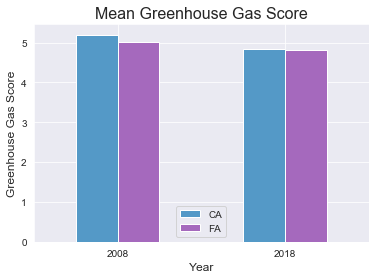

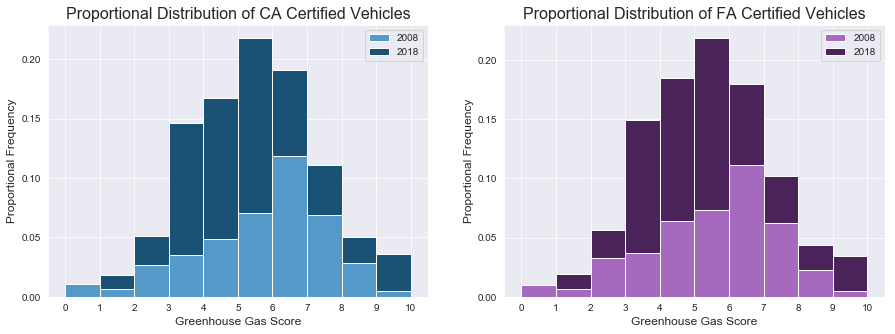

In [178]:
colors = ['#5499c7', '#1a5276', '#a569bd','#4a235a']
labels = ['2008','2018']
dist_funct('greenhouse_gas_score', 'Greenhouse Gas Score')

Although the average greenhouse gas score for 2018 is lower than the 2008 average score (4.84 vs 5.19), the 2008 scores are more distributed to the left than the 2018 scores.

Similar to CA certified vehicles, the average greenhouse gas score for 2018 is lower than the 2008 average score (4.80 vs 5.02). However, the 2018 scores are distributed to the left while the 2008 scores are distributed to the right.

#### How has the distribution of combined mpg changed from 2008 to 2018?

CA Certified Vehicles
Mean minus Median for 2008 = -0.21175278622087035
Mean minus Median for 2018 = 1.8282163742690045


FA Certified Vehicles
Mean minus Median for 2008 = 0.21174205967276194
Mean minus Median for 2018 = 1.6243798724309002


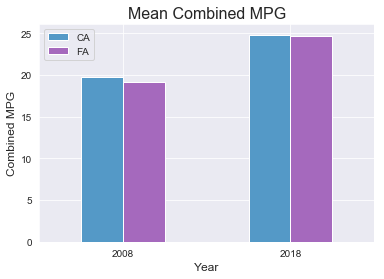

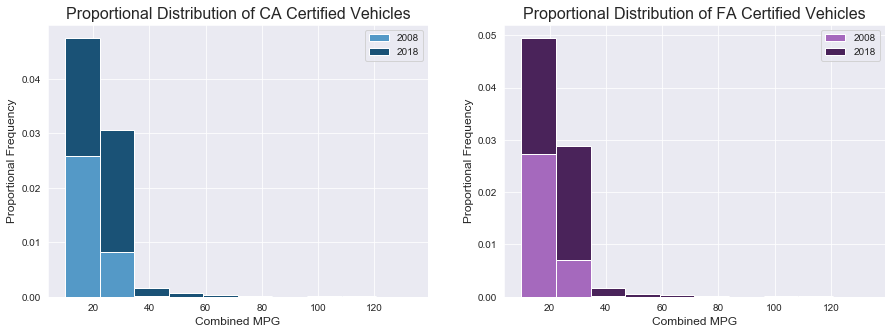

In [179]:
dist_funct('cmb_mpg', 'Combined MPG')

For both CA and FA certified vehicles, the average combined MPG has increased from 2008 to 2018 by approximately 5 mpg. CA certified vehicles in 2008 were slightly skewed to the left, while the other distributions were skewed right.

#### How are displacement and combined mpg correlated?

In [180]:
def corr_funct(df1, df2, title, y_col, xaxis, yaxis, colour):
    
    series1 = df1[y_col]
    series2 = df1.cmb_mpg
    series3 = df2[y_col]
    series4 = df2.cmb_mpg
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    
    ax1.scatter(x=series1, y=series2, c=colour)
    ax1.set_title(title.format('2008'), fontsize=16)
    ax1.set_xlabel(xaxis, fontsize=12)
    ax1.set_ylabel(yaxis, fontsize=12)
    
    ax2.scatter(x=series3, y=series4, c=colour)
    ax2.set_title(title.format('2018'), fontsize=16)
    ax2.set_xlabel(xaxis, fontsize=12)
    ax2.set_ylabel(yaxis, fontsize=12)

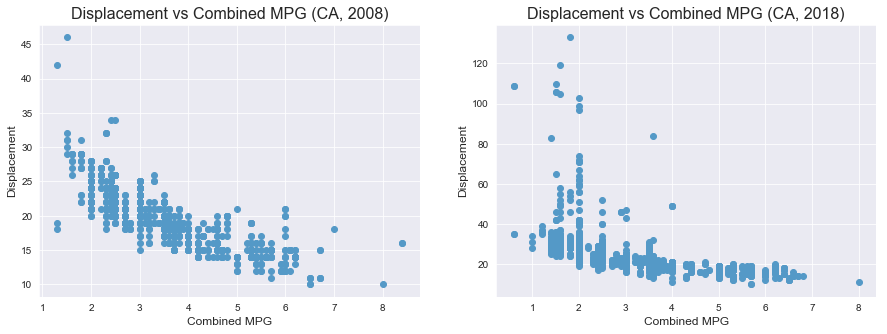

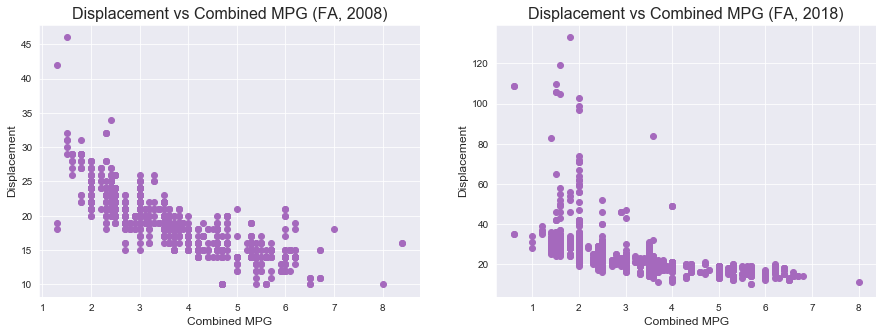

In [181]:
y_col = 'displ'
xlabel = "Combined MPG"
ylabel = "Displacement"
title = ylabel + " vs " + xlabel
corr_funct(ca_08, ca_18, title + " (CA, {})", y_col, xlabel, ylabel, colors[0])
corr_funct(fa_08, fa_18, title + " (FA, {})", y_col, xlabel, ylabel, colors[2])

Displacement and Combined MPG are negatively correlated for all 2008 and 2018 vehicles, regardles of the certification.

#### How are greenhouse gas scores and combined mpg correlated?

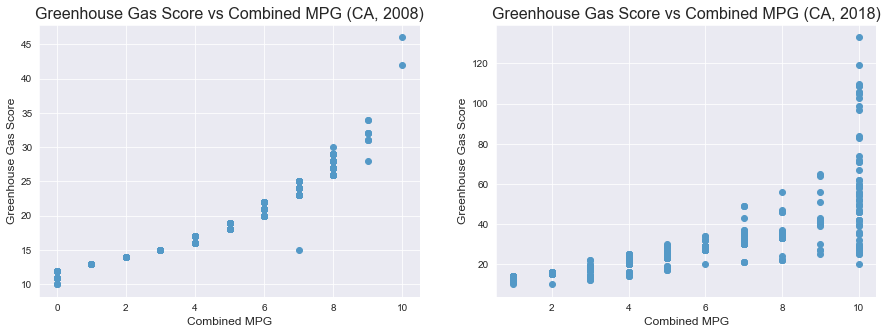

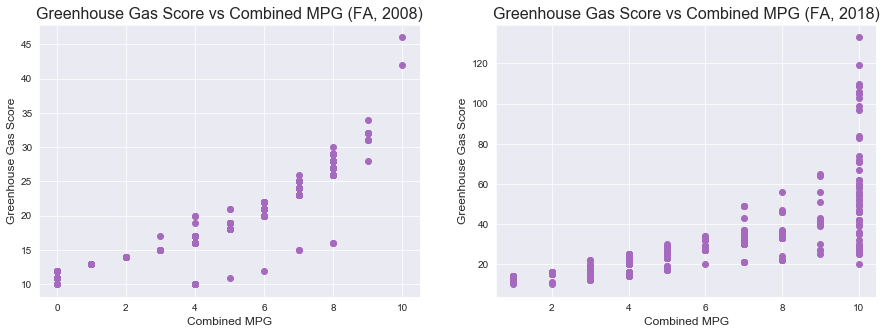

In [182]:
y_col = 'greenhouse_gas_score'
xlabel = "Combined MPG"
ylabel = "Greenhouse Gas Score"
title = ylabel + " vs " + xlabel
corr_funct(ca_08, ca_18, title + " (CA, {})", y_col,xlabel, ylabel, colors[0])
corr_funct(fa_08, fa_18, title + " (FA, {})", y_col, xlabel, ylabel, colors[2])

Greenhouse Gas Scores and Combined MPG are positively correlated for all 2008 and 2018 vehicles, regardles of the certification.

#### How has alternative fuel usage changed from 2008 to 2018? 

Chg in Number of Models using Alternative fuels (CA Certified):  74
Chg in Number of Models using Alternative fuels (FA Certified):  62


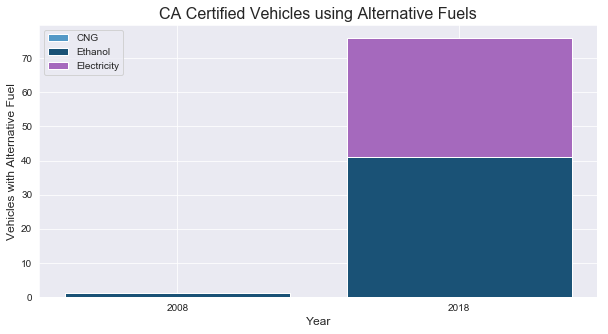

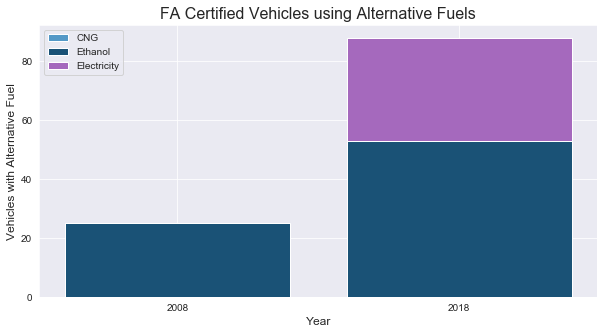

In [216]:
def alt_fuel_count(temp_08, temp_18, title):
    
    temp_08 = temp_08.value_counts()
    temp_18 = temp_18.value_counts()
    
    #identifies missing alt fuel values and inputs a zero
    for f in alternative_fuel:
        if not f in temp_08.index:
            temp_08[f] = 0
        if not f in temp_18.index:
            temp_18[f] = 0
                
    
    f, (ax1) = plt.subplots(1, 1, figsize=(10,5))
    
    #combines values for each fuel type
    cng = [temp_08.Cng, temp_18.Cng]
    ethanol = [temp_08.Ethanol, temp_18.Ethanol]
    electr = [temp_08.Electricity, temp_18.Electricity]
    
    ind = np.arange(len(cng))
    
    #generates bar chart
    ax1.bar(ind, cng, color=colors[0], bottom=electr, label='CNG')
    ax1.bar(ind, ethanol, color=colors[1], bottom=0, label='Ethanol')
    ax1.bar(ind, electr, color=colors[2], bottom=ethanol, label='Electricity')
    
    #formats chart
    ax1.legend()
    ax1.set_xlabel('Year', fontsize=12)
    ax1.set_ylabel('Vehicles with Alternative Fuel',fontsize=12)
    ax1.set_title(title,fontsize=16)
    ax1.set_xticks([0,1])
    ax1.set_xticklabels(labels)
    
     
    temp_08 = temp_08.filter(alternative_fuel)
    temp_18 = temp_18.filter(alternative_fuel)
    
    #new_df = pd.concat([temp_08,temp_18], axis=1, sort=True).reset_index()
    #new_df.columns = ['fuel type', '2008', '2018']
   
    return temp_18.sum() - temp_08.sum()



#normalizes the fuel type values in the 2008 dataframes
ca_08.fuel = ca_08.fuel.str.title()
fa_08.fuel = fa_08.fuel.str.title()

#list of alternative fuels
alternative_fuel = ['Cng', 'Ethanol', 'Electricity']

print("Chg in Number of Models using Alternative fuels (CA Certified): ", 
      alt_fuel_count(ca_08.fuel, ca_18.fuel, "CA Certified Vehicles using Alternative Fuels"))

print("Chg in Number of Models using Alternative fuels (FA Certified): ", 
      alt_fuel_count(fa_08.fuel, fa_18.fuel, "FA Certified Vehicles using Alternative Fuels"))


Across CA and FA certified vehicles, CNG usage decreased to 0 from 2008 to 2018 while electricity and ethanol fueled vehicles increased. For CA certified vehicles, ethanol fueled vehicles increased the most during the time period while electric vehicles had the highest growth for FA certified vehicles.

#### Are more unique models using alternative fuels in 2018 compared to 2008? By how much?

Change in number of unique models using alternative fuels (CA):  50
Change in number of unique models using alternative fuels (FA):  44


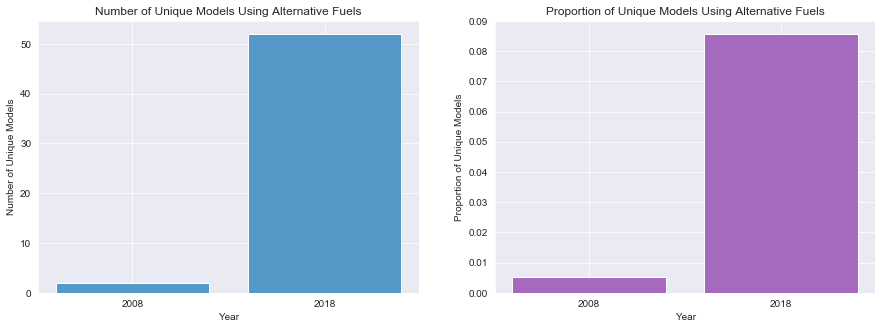

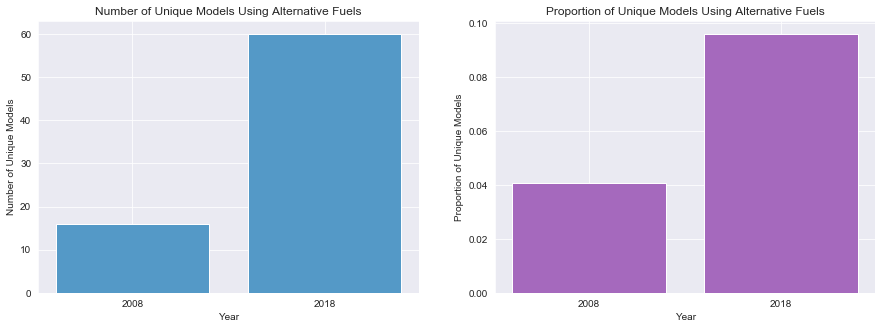

In [241]:
def uniquemodeldiff(temp_08, temp_18, head):

    alt_18 = temp_18.query('fuel in {}'.format(alternative_fuel)).model.nunique()
    alt_08 = temp_08.query('fuel in {}'.format(alternative_fuel)).model.nunique()
    
    total_08 = temp_08.model.nunique()
    total_18 = temp_18.model.nunique()
    prop_08 = alt_08 / total_08
    prop_18 = alt_18 / total_18
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    
    ax1.bar(labels, [alt_08, alt_18], color=colors[0])
    ax1.set_title("Number of Unique Models Using Alternative Fuels")
    ax1.set_xlabel("Year")
    ax1.set_ylabel("Number of Unique Models");
    
    ax2.bar(labels, [prop_08, prop_18], color=colors[2])
    ax2.set_title("Proportion of Unique Models Using Alternative Fuels")
    ax2.set_xlabel("Year")
    ax2.set_ylabel("Proportion of Unique Models");
    
    print(head, str(alt_18-alt_08))

uniquemodeldiff(ca_08, ca_18, "Change in number of unique models using alternative fuels (CA): ")
uniquemodeldiff(fa_08, fa_18, "Change in number of unique models using alternative fuels (FA): ")

The number of unique models that use alternative fuels has increased by 50 for CA certified vehicles and 44 for FA certified vehicles between 2008 and 2018.

#### How much have vehicle classes improved in fuel economy?

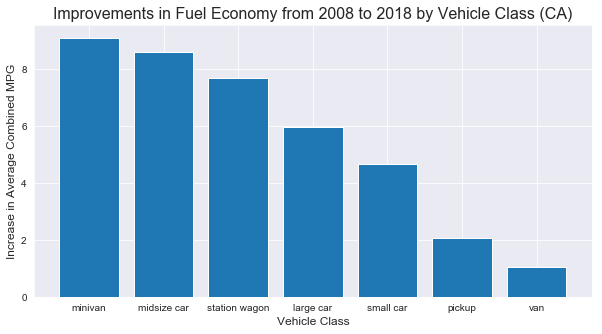

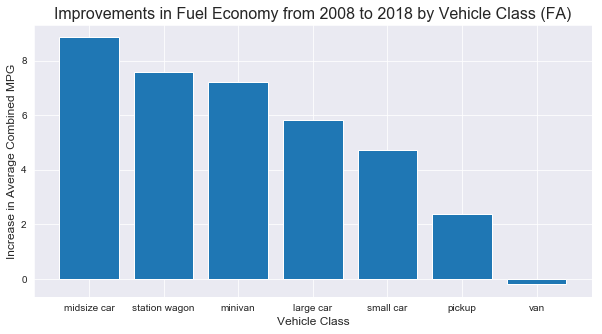

In [240]:
def fuel_economy_by_class(temp_08, temp_18, cert):

    chg = (temp_18.groupby('veh_class').cmb_mpg.mean() - temp_08.groupby('veh_class').cmb_mpg.mean()).dropna()
    chg.sort_values(ascending=False,inplace=True)

    f, (ax) = plt.subplots(1, 1, figsize=(10,5))

    ax.bar(chg.index, chg)
    ax.set_title('Improvements in Fuel Economy from 2008 to 2018 by Vehicle Class ({})'.format(cert), fontsize=16)
    ax.set_xlabel('Vehicle Class', fontsize=12)
    ax.set_ylabel('Increase in Average Combined MPG', fontsize=12);

fuel_economy_by_class(ca_08, ca_18, "CA")
fuel_economy_by_class(fa_08, fa_18, "FA")

The minivan saw the greatest improvement in fuel economy for CA certified vehicles while the midsize car had the most improvement for FA certified vehicles between 2008 and 2018. For FA certified vehicles, the van actually decreased slightly in average combined mpg.

#### What are the characteristics of SmartWay vehicles? Have they changed over time? (mpg, greenhouse gas)

#### What features are associated with better fuel economy (mpg)?

#### For all of the models that were produced in 2008 that are still being produced in 2018, how much has the mpg improved and which vehicle improved the most? (use merge)